# Changing the Error Tolerance at Runtime

**An example to change numerical settings using a callback in IFM.**

FEFLOW's adaptive time stepping scheme determines the optimal time step by comparing the error norm (e.g. the RMS of the nodal values between two consecutive time steps) with a desired value $\epsilon$, which is the error tolerance aka termination criterion.

This example runs a transient model with two different fixed error tolerances ($\epsilon=1 \cdot e^{-3}$ and $\epsilon=1\cdot e^{-5}$) to show the difference in time stepping behavior (smaller error tolerance leads to smaller time steps).

In a second step, the script implements a callback that can change the error tolerance during the simulation run. The input is taken from a time series that specifies a smaller (stricter) error tolerance during a time interval mid-way during the simulation.

*Note: This example uses ifm_contrib for non-essential features like plotting and create the time series. See [dhi.github.io/ifm_contrib](https://dhi.github.io/ifm_contrib)* for more information.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["FEFLOW_KERNEL_VERSION"]="74"
import ifm_contrib as ifm
ifm.getKernelVersion()

7402

## Default Error Tolerance

First we run the model with default error tolerance ($\epsilon=1 \cdot e^{-3}$) and record the time step history. 

In [2]:
# load and run
doc = ifm.loadDocument("../data/unittests/models/example_2D.fem")
doc.startSimulator()

# record time step history, then close
df_ts1e3 = doc.c.hist.df.TIMES
doc.closeDocument()

## Reduced Error Tolerance

Second, we re-run the model with stricter error tolerance ($\epsilon=1 \cdot e^{-5}$) and compare the time step behaviour

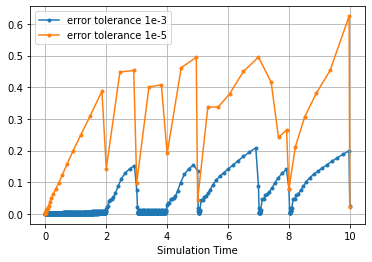

In [3]:
# reload
doc = ifm.loadDocument("../data/unittests/models/example_2D.fem")

# set smaller time step tolerance and re-run
doc.setTimeSteppingErrorTolerance(1e-5)
doc.startSimulator()

# record time steps and close
df_ts1e4 = doc.c.hist.df.TIMES
doc.closeDocument()

# compare both time steps
ax1 = df_ts1e4.plot(style=".-")
df_ts1e3.plot(ax=ax1, style=".-")
ax1.grid()
ax1.legend(["error tolerance 1e-3", "error tolerance 1e-5"])
None

The decrease of the time step length for the stricter error criterion can be easily seen.

## Varying Error Tolerance

We will now control the error tolerance dynamically, using a time series to specify the error tolerance value along the simulation time axis.

The time series can be created and edited in the FEFLOW GUI (Time Series Editor), for the sake of this example we will create it on the fly using an `ifm_contrib` extension (using time series ID `30`).

The error tolerance will be set to 1e-3 at start, reduced to 1e-5 at 4 days simulation time and reset to 1e-3 at 6 days.

In [4]:
# reload the model

doc = ifm.loadDocument("../data/unittests/models/example_2D.fem")

# add time series (ID 30) with smaller error tolerance between 4 and 8 days simulation time
ds_error_crit=pd.Series([1e-3, 1e-5, 1e-3],  
                        [0,    4,    6])
doc.c.ts.df.create_from_series(tsid=30, 
                               series=ds_error_crit,
                               comment="error_crit",
                               interpolation=ifm.Enum.INTERPOL_CONST)
# check values
ds_error_crit

0    0.00100
4    0.00001
6    0.00100
dtype: float64

Next comes the implementation of the `preTimeStep()` callback. If a function with this name exists, the code is executed before each time step. 

The code does the following:
+ read the current simulation time
+ interpolate the time series values at current simulation time
+ set the error tolerance to this value.

In [5]:
def preTimeStep(doc):
    t = doc.getAbsoluteSimulationTime()
    epsilon = doc.powerInterpolateValue(30, t)
    doc.setTimeSteppingErrorTolerance(epsilon)

These lines may also be copied into the scripting menu of FEFLOW to make it persistent in the model (see figure below).

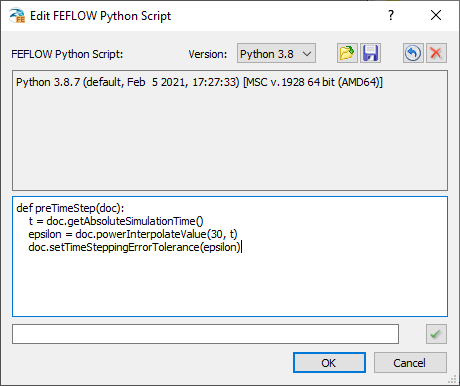

Finally, running the simulator and comparing the results shows that the time step is reduced during a part of the model period. This allows for greater accuracy and defense against instability during this period without slowing the simulation down during the remainder of the model run.

In [6]:
doc.startSimulator()

time step tolerance : 0.001


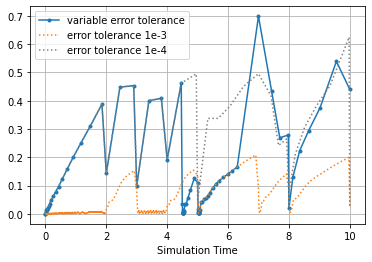

In [7]:
# with variable error tolerance
ax1 = doc.c.hist.df.TIMES.plot(style=".-")
df_ts1e4.plot(ax=ax1, style=":")
df_ts1e3.plot(ax=ax1, style=":", color="grey")
ax1.grid()
ax1.legend(["variable error tolerance", "error tolerance 1e-3", "error tolerance 1e-4"])
print(f"time step tolerance : {doc.getTimeSteppingErrorTolerance()}")